In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

In [4]:
def annualize_weekly_ret(weekly_ret):
    return (1 + weekly_ret / 7) ** 365 - 1

## Input

In [5]:
chain = 'Arbitrum'

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Traders Net PnL'):
        fnames['Traders Net PnL'] = fname  
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
        
fnames

{'Fees': 'Fees_2021-08-31_2022-09-11.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2021-08-31_2022-09-11.csv',
 'Traders Net PnL': 'Traders Net PnL_2021-08-31_2022-09-11.csv',
 'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-09-11.csv'}

In [7]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Fees Data

In [8]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'

# calc daily total fees
df_fees['total_fees'] = df_fees.sum(axis=1)

print(df_fees.info())
df_fees.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 377 entries, 2021-08-31 to 2022-09-11
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            377 non-null    float64
 1   margin_trading_fees  377 non-null    float64
 2   mint_glp_fees        377 non-null    float64
 3   burn_glp_fees        377 non-null    float64
 4   liquidation_fees     377 non-null    float64
 5   total_fees           377 non-null    float64
dtypes: float64(6)
memory usage: 20.6 KB
None


,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2021-08-31,0.3993,0.1533,0.1183,0.2062,0.0000,0.8770
2021-09-01,866.3653,101.8488,"4,843.2267",0.0337,0.0000,"5,811.4746"
2021-09-02,854.0028,741.7089,"1,610.5278",134.2650,0.0000,"3,340.5044"
2021-09-03,"1,388.2414","3,127.2669",22.3804,0.0000,0.0000,"4,537.8886"
2021-09-04,219.0247,768.7568,82.8838,0.0000,0.0000,"1,070.6653"


## Prep Traders' PnL Data

In [9]:
df_trader_pnl = (pd.read_csv(os.path.join(data_dir, chain, fnames['Traders Net PnL']), 
                             parse_dates=['Date'], index_col='Date', usecols=range(2))
                   .rename(columns = {'Net PnL': 'trader_pnl'})
                )
df_trader_pnl.head()

,trader_pnl
Date,
2021-08-31,0.0000
2021-09-01,-4.3068
2021-09-02,-516.8955
2021-09-03,"25,358.9416"
2021-09-04,-585.2186


## Prep GLP USD Value Data

In [10]:
# In the 'AUM & Glp Supply' file, col `aum` is in $, and `glpSupply` in quantity/count; 
# each row is the total stock measured at the end of the day. 
#
# I checked that `aum` == `glpSupply` * `glpPrice`, where `glpPrice` is from the 'Glp Price Comparison' file.
# So this `aum` is only a GLP `aum`, and it doesn't include staked GMX. So it doesn't capture the full picture. 
# Let's ignore it.
# 
# To calculate the net GLP supply (mint amount - burn amount) for each day, 
# - take the difference of total stock of glpSupply between two consecutive dates. 
# To calculate the net dollar flow for each day, simply do
# - net supply * (daily avg) glp price, which can be taken from the price file.

daily_stock = pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                          parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
# drop the last row because the most recent date may not be a full day
daily_stock = daily_stock.iloc[:-1, :]
daily_stock.head()

,glpSupply
Date,
2021-08-31,"8,229.0548"
2021-09-01,"973,717.9555"
2021-09-02,"1,620,503.2873"
2021-09-03,"1,624,108.2897"
2021-09-04,"1,668,759.9557"


In [11]:
# calculate daily flow by taking the difference between today's stock and yesterday's 
daily_flow = daily_stock.diff()
daily_flow.head()

,glpSupply
Date,
2021-08-31,NaN
2021-09-01,"965,488.9007"
2021-09-02,"646,785.3318"
2021-09-03,"3,605.0024"
2021-09-04,"44,651.6660"


In [12]:
daily_prices = pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpPrice'])
daily_prices.head()

,glpPrice
Date,
2021-08-31,1.1935
2021-09-01,1.2933
2021-09-02,1.2883
2021-09-03,1.3062
2021-09-04,1.3077


In [13]:
# calculate net dollar flow for GLP
daily_flow = (pd.merge(daily_flow, daily_prices.loc[:, 'glpPrice'], left_index=True, right_index=True)
                .assign(net_dollar_flow = lambda x: x.glpSupply * x.glpPrice)
                .drop(['glpSupply', 'glpPrice'], axis=1)
                .dropna() # drop missing rows
             )
daily_flow.head()

,net_dollar_flow
Date,
2021-09-01,"1,248,702.1227"
2021-09-02,"833,226.5943"
2021-09-03,"4,708.9158"
2021-09-04,"58,389.3636"
2021-09-05,"34,078.1657"


## Join Daily Data 

In [14]:
df = df_fees.loc[:, ['total_fees']].join(df_trader_pnl).join(daily_flow)

# drop the first row because nearly no activity on day 1
# drop the last row because the most recent date may not be a full day
df = df.iloc[1:-1, :]

if chain == 'Avalanche':
    df = df.loc['2022-01-07':, :] # all days before have tiny numbers, probably before official launch

df.head()

,total_fees,trader_pnl,net_dollar_flow
Date,,,
2021-09-01,"5,811.4746",-4.3068,"1,248,702.1227"
2021-09-02,"3,340.5044",-516.8955,"833,226.5943"
2021-09-03,"4,537.8886","25,358.9416","4,708.9158"
2021-09-04,"1,070.6653",-585.2186,"58,389.3636"
2021-09-05,"1,167.3130","1,209.2906","34,078.1657"


## Roll up to Weekly Level and Final Prep

In [15]:
weekly_index = df.index.to_period('W')

In [16]:
weekly_ndf = df.groupby(weekly_index).net_dollar_flow.sum()
weekly_ndf.index.name = 'Week'
weekly_ndf.head()

Week
2021-08-30/2021-09-05   2,179,105.1621
2021-09-06/2021-09-12   9,562,918.0862
2021-09-13/2021-09-19   8,068,198.5426
2021-09-20/2021-09-26   8,943,695.4552
2021-09-27/2021-10-03   2,845,555.2625
Freq: W-SUN, Name: net_dollar_flow, dtype: float64

In [17]:
weekly_glp_usd = weekly_ndf.cumsum()
weekly_glp_usd.head()
weekly_glp_usd.name = 'glp_aum'

In [18]:
weekly_fees = df.groupby(weekly_index).total_fees.sum()
weekly_fees.index.name = 'Week'
weekly_fees.head()

Week
2021-08-30/2021-09-05    15,927.8459
2021-09-06/2021-09-12   117,985.6876
2021-09-13/2021-09-19   212,762.6947
2021-09-20/2021-09-26   485,034.2381
2021-09-27/2021-10-03   304,894.8721
Freq: W-SUN, Name: total_fees, dtype: float64

In [19]:
weekly_pnl = df.groupby(weekly_index).trader_pnl.sum() 
weekly_pnl.index.name = 'Week'
weekly_pnl.head()

Week
2021-08-30/2021-09-05       25,461.8113
2021-09-06/2021-09-12       10,945.7632
2021-09-13/2021-09-19       46,053.3055
2021-09-20/2021-09-26   -1,651,522.6813
2021-09-27/2021-10-03      224,895.3212
Freq: W-SUN, Name: trader_pnl, dtype: float64

In [20]:
ha = pd.merge(weekly_glp_usd, weekly_fees, left_index=True, right_index=True)
df_weekly = pd.merge(ha, weekly_pnl, left_index=True, right_index=True)
df_weekly.head()

,glp_aum,total_fees,trader_pnl
Week,,,
2021-08-30/2021-09-05,"2,179,105.1621","15,927.8459","25,461.8113"
2021-09-06/2021-09-12,"11,742,023.2483","117,985.6876","10,945.7632"
2021-09-13/2021-09-19,"19,810,221.7909","212,762.6947","46,053.3055"
2021-09-20/2021-09-26,"28,753,917.2461","485,034.2381","-1,651,522.6813"
2021-09-27/2021-10-03,"31,599,472.5086","304,894.8721","224,895.3212"


In [21]:
# 1% of protocol fees goes to keeper, and 70% of the rest goes to GLP holders
df_weekly['yield'] = df_weekly['total_fees'] * 0.99 * 0.7 

# all traders' PnL goes to GLP holders
df_weekly['glp_pnl'] = -1 * df_weekly['trader_pnl'] 

df_weekly.head()

,glp_aum,total_fees,trader_pnl,yield,glp_pnl
Week,,,,,
2021-08-30/2021-09-05,"2,179,105.1621","15,927.8459","25,461.8113","11,037.9972","-25,461.8113"
2021-09-06/2021-09-12,"11,742,023.2483","117,985.6876","10,945.7632","81,764.0815","-10,945.7632"
2021-09-13/2021-09-19,"19,810,221.7909","212,762.6947","46,053.3055","147,444.5474","-46,053.3055"
2021-09-20/2021-09-26,"28,753,917.2461","485,034.2381","-1,651,522.6813","336,128.7270","1,651,522.6813"
2021-09-27/2021-10-03,"31,599,472.5086","304,894.8721","224,895.3212","211,292.1464","-224,895.3212"


In [22]:
# GLP's return from protocol revenue
df_weekly['ret_from_yield'] = annualize_weekly_ret(df_weekly['yield'] / df_weekly['glp_aum']) * 100
# GLP's return from traders' PnL
df_weekly['ret_from_trader_pnl'] = annualize_weekly_ret(df_weekly['glp_pnl'] / df_weekly['glp_aum']) * 100 
# GLP's total return
df_weekly['total_ret'] = annualize_weekly_ret((df_weekly['yield'] + df_weekly['glp_pnl']) / df_weekly['glp_aum']) * 100
df_weekly_ret = df_weekly.loc[:, ['ret_from_yield', 'ret_from_trader_pnl', 'total_ret']]
df_weekly_ret.head()

,ret_from_yield,ret_from_trader_pnl,total_ret
Week,,,
2021-08-30/2021-09-05,30.2165,-45.6526,-29.1995
2021-09-06/2021-09-12,43.7506,-4.7448,36.9366
2021-09-13/2021-09-19,47.3861,-11.4177,30.5748
2021-09-20/2021-09-26,83.8653,"1,874.0652","3,511.6901"
2021-09-27/2021-10-03,41.6927,-31.0158,-2.2197


## Summary Statistics

In [23]:
# summary stats
format_dict = {'ret_from_yield': '{:.1%}', 'ret_from_trader_pnl': '{:.1%}', 'total_ret': '{:.1%}'}
weekly_ret_summ = (df_weekly_ret/100).describe().iloc[1:].style.format(format_dict)
dfi.export(weekly_ret_summ, os.path.join(save_fig_dir, 'glp_weekly_ret_summary.png'))

/usr/local/lib/python3.8/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0911/105452.646461:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmpapj54m24/temp.png.


In [24]:
df_weekly_ret.loc[:, ['ret_from_yield', 'ret_from_trader_pnl']].corr()

,ret_from_yield,ret_from_trader_pnl
ret_from_yield,1.0000,0.3405
ret_from_trader_pnl,0.3405,1.0000


In [25]:
# what if we remove traders' big losses?
is_big_trader_loss = df_weekly_ret.ret_from_trader_pnl >= 100
df_weekly_ret.loc[~is_big_trader_loss, ['ret_from_yield', 'ret_from_trader_pnl']].corr()

,ret_from_yield,ret_from_trader_pnl
ret_from_yield,1.0000,-0.4800
ret_from_trader_pnl,-0.4800,1.0000


## Plot GLP Weekly Returns

Return Sources:

- protocol fees
- traders' PnL

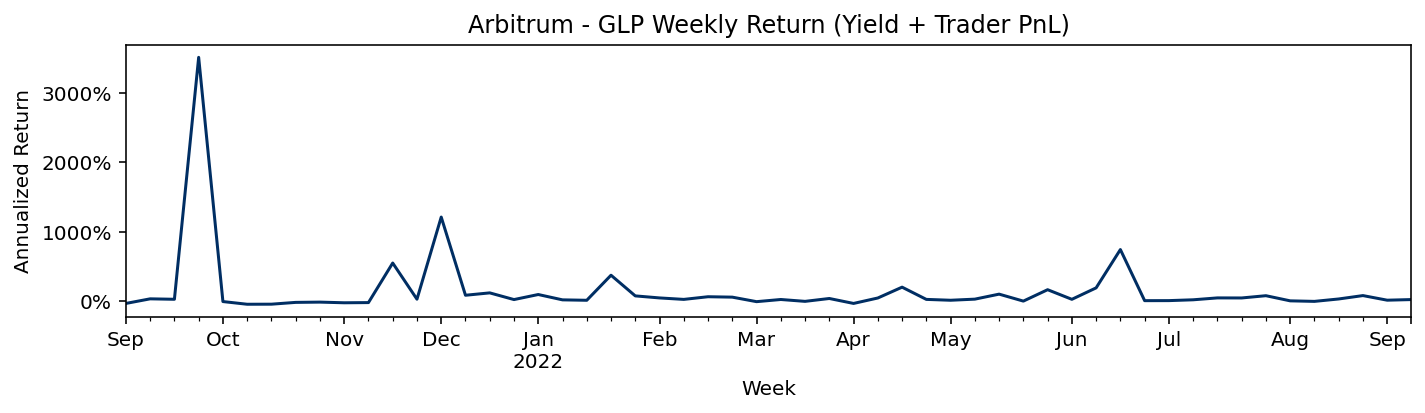

In [26]:
# plot total returns
y = df_weekly_ret.total_ret
ax = y.plot(color='#002e63')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Annualized Return')
plt.title("{} - GLP Weekly Return (Yield + Trader PnL)".format(chain)) 
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'glp_total_ret.png'), dpi=300);

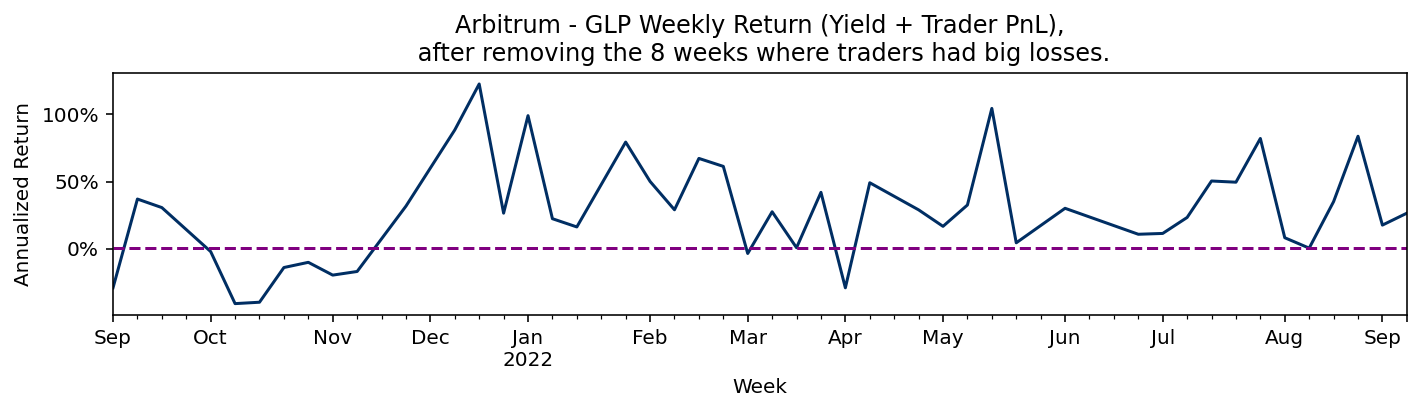

In [27]:
# remove the big outliers (>= 100%)
ax = y[~is_big_trader_loss].plot(color='#002e63')
ax.axhline(0.5, linestyle='--', color='purple')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Annualized Return')
subtit = '\n after removing the {} weeks where traders had big losses.'.format(is_big_trader_loss.sum()) 
plt.title("{} - GLP Weekly Return (Yield + Trader PnL),".format(chain) + subtit) 
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'glp_total_ret_zoomin.png'), dpi=300);

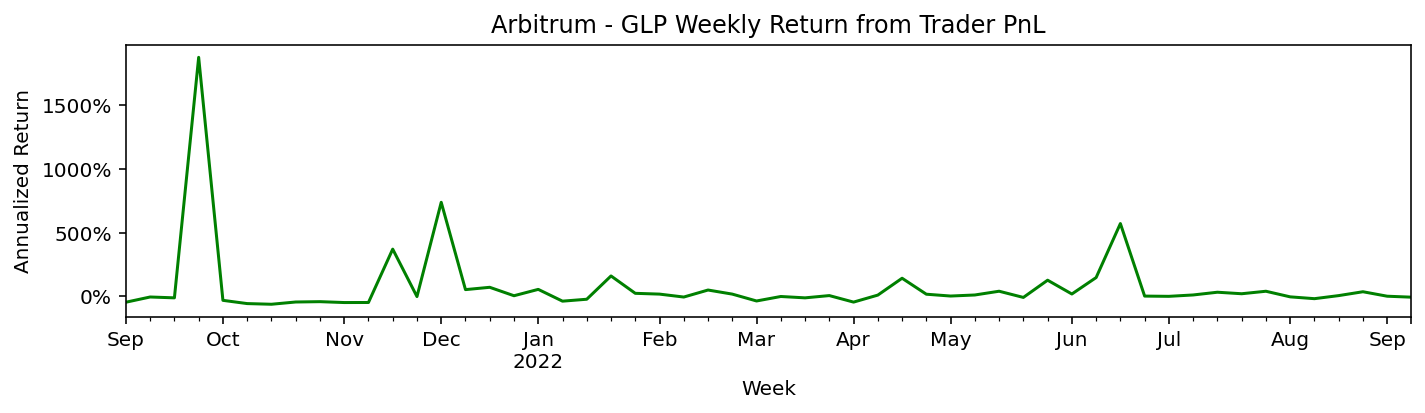

In [28]:
# plot returns from Traders' PnL
y = df_weekly_ret['ret_from_trader_pnl']
ax = y.plot(color='#008000')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Annualized Return')
plt.title("{} - GLP Weekly Return from Trader PnL".format(chain)) 
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'glp_ret_from_trader_pnl.png'), dpi=300);

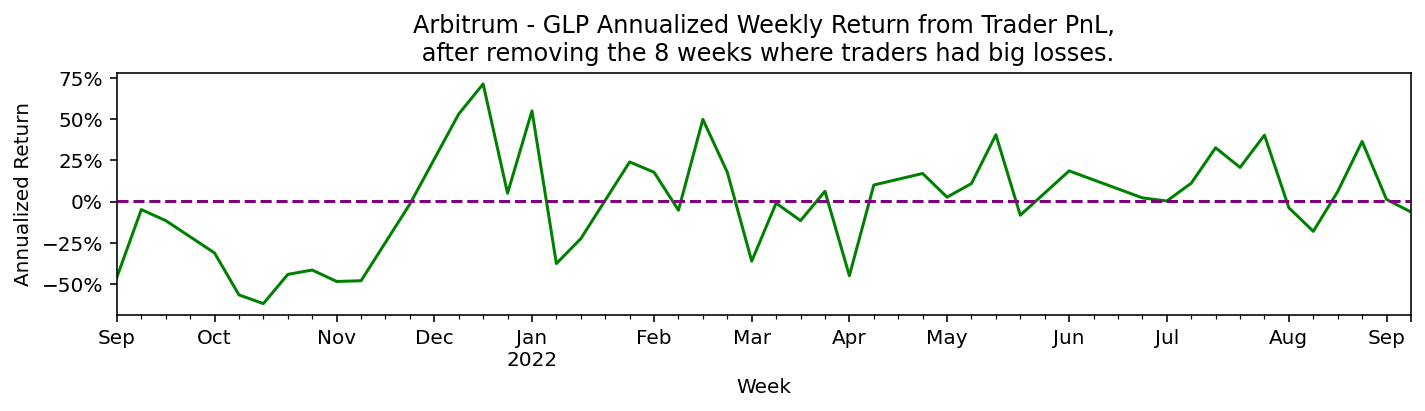

In [29]:
# remove the big outliers (>= 100%)
ax = y[~is_big_trader_loss].plot(color='#008000')
ax.axhline(0.5, linestyle='--', color='purple')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Annualized Return')
subtit = '\n after removing the {} weeks where traders had big losses.'.format(is_big_trader_loss.sum()) 
plt.title("{} - GLP Annualized Weekly Return from Trader PnL,".format(chain) + subtit) 
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'glp_ret_from_trader_pnl_zoomin.png'), dpi=300);

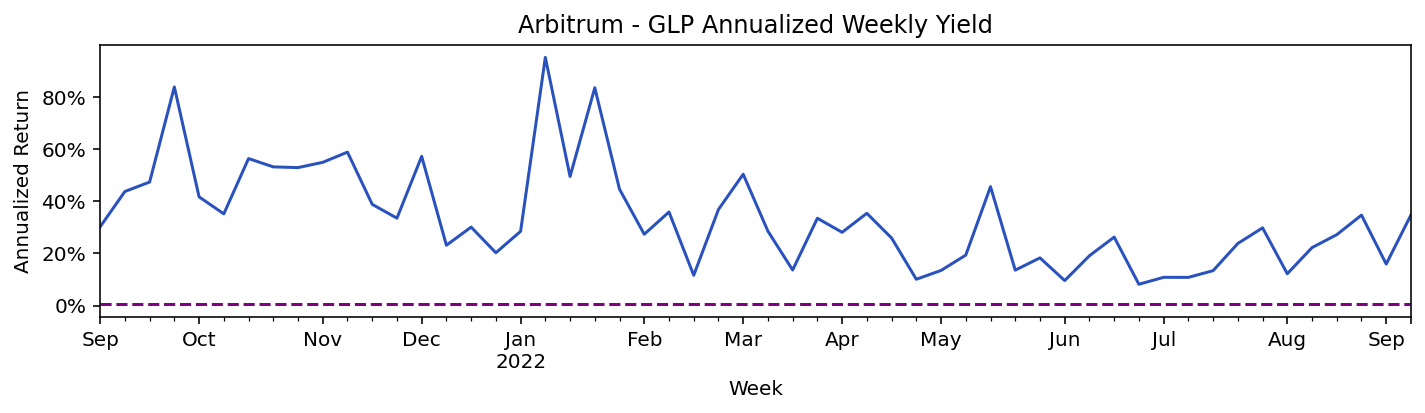

In [30]:
# plot returns from yield
y = df_weekly_ret['ret_from_yield']
ax = y.plot(color='#2a52be')
ax.axhline(0.5, linestyle='--', color='purple')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Annualized Return')
plt.title("{} - GLP Annualized Weekly Yield".format(chain)) 
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'glp_ret_from_yield.png'), dpi=300);